## ELL409: ASSIGNMENT 2

# Neural Networks

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import matplotlib
import seaborn as sb

In [2]:
X = np.array(pd.read_table('training_images.txt',header=None))
y = np.array(pd.read_table('training_labels.txt',header=None))

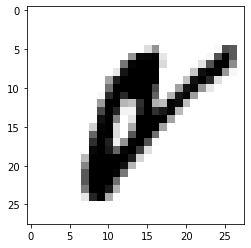

In [3]:
some_digit = X[147]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")

In [4]:
print(y[147])

[9]


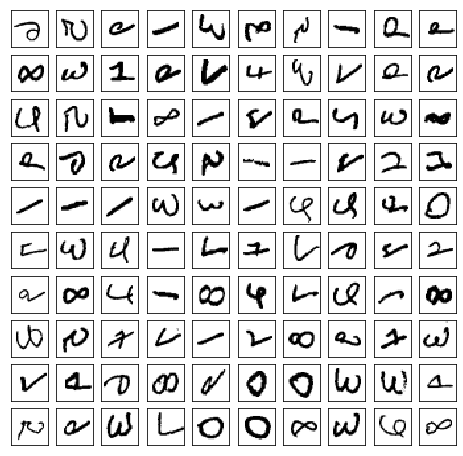

In [5]:
def plot_100_images(X):
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # Randomly select 100 samples
    sample_images = X[sample_idx, :]  # (100,784)
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for row in range(10):
        for column in range(10):
            ax_array[row, column].matshow(sample_images[10 * row + column].reshape((28, 28)),
                                   cmap='gray_r')
    plt.xticks([])   # disable xticks
    plt.yticks([])        
    plt.show()
plot_100_images(X)

In [6]:
def my_train_test_split(X, y,train_size):
    
    indices = np.random.permutation(X.shape[0])
    train_ind, test_ind = indices[:int(train_size*X.shape[0])], indices[int(train_size*X.shape[0]):]
    
    X_train = X[train_ind, :]
    y_train = y[train_ind, :]
    X_test = X[test_ind, :]
    y_test = y[test_ind, :]
    
    X_train = X_train.T
    X_test = X_test.T
    y_train = y_train.T
    y_test = y_test.T

    return X_train, X_test, y_train, y_test

In [7]:
def one_hot_encoder(y):
    y = y.T
    y_transform = np.zeros((10,y.shape[1]))
    y_transform[y,np.arange(y.shape[1])] = 1
    return y_transform.T

In [8]:
y = one_hot_encoder(y)
y.shape

(5000, 10)

In [9]:
X_train, X_test, y_train, y_test= my_train_test_split(X, y,train_size = 0.8)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(784, 4000)
(10, 4000)
(784, 1000)
(10, 1000)


In [10]:
def xavier_inititalization(layers):
    parameters = {}           
    for i in range(1, len(layers)):  
        a = layers[i] + layers[i-1]
        epsilon = math.sqrt(6)/math.sqrt(a)
        parameters['W' + str(i)] = np.random.uniform(low = -epsilon,high = epsilon, size=(layers[i], layers[i-1])) 
        parameters['b' + str(i)] = np.zeros((layers[i], 1))
    
    return parameters

In [11]:
def optimization_initialization(layers):
    oparams = {}
    for i in range(1,len(layers)):
        oparams['vdw' + str(i)] = np.zeros((layers[i], layers[i-1]))
        oparams['sdw' + str(i)] = np.zeros((layers[i], layers[i-1]))
        oparams['vdb' + str(i)] = np.zeros((layers[i], 1))
        oparams['sdb' + str(i)] = np.zeros((layers[i], 1))
    return oparams

In [12]:
def cost_function(Y_Predicted,Y):
    cost = (-np.multiply(Y,np.log(Y_Predicted))).mean()
    return cost

In [13]:
def sigmoid(Z):
    Z = np.clip(Z ,a_min = -100, a_max = 100)
    A = 1/(1+np.exp(-Z))
    A = np.clip(A,a_min = 10**-7, a_max = 1-(10**-7))
    cache = Z
    return A, cache

def leaky_relu(Z):
    A = np.maximum(0.01*Z, Z)
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)    
    cache = Z 
    return A, cache

def tanh(Z):
    A = np.tanh(Z)
    cache = Z
    return A, cache

def softmax(Z):
    Z = np.clip(Z ,a_min = -100, a_max = 100)
    e_x = np.exp(Z)
    A = e_x / np.sum(e_x,axis = 0)  
    cache = Z
    return A,cache 

In [14]:
def forward_prop(X,parameters,activation_function):

    caches = []
    A = X
    n = len(parameters) // 2  

    for i in range(1, n):
        
        A_previous = A 
        linear_cache = (A_previous,parameters['W' + str(i)],parameters['b' + str(i)])
        Z = np.dot(parameters['W' + str(i)],A_previous) + parameters['b' + str(i)]
        
        if(activation_function == "relu"):
            A, activation_cache = relu(Z)
        elif(activation_function == 'sigmoid'):
            A, activation_cache = sigmoid(Z)
        elif(activation_function == "tanh"):
            A, activation_cache = tanh(Z)
        elif(activation_function == "leaky_relu"):
            A, activation_cache = leaky_relu(Z) 
            
        cache = (linear_cache, activation_cache)
        caches.append(cache)
            
    linear_cache = (A,parameters['W' + str(n)],parameters['b' + str(n)] )           
    Z = np.dot(parameters['W' + str(n)],A) + parameters['b' + str(n)]
    activations, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    caches.append(cache)
    
    return activations, caches

In [15]:
def optimizer_algo(optimizer,parameters, grads, lr, layers, regularization, alpha , alpha2):

    #Gradient Descent
    oparams = optimization_initialization(layers)
    
    if(optimizer == 'gd'):
        if(regularization == None):
            for i in range( len(layers)-1 ):
                parameters['W' + str(i+1)] = parameters['W' + str(i+1)] - ( lr * grads['dW' + str(i+1)]) # + (lr*0.1*parameters["W" + str(i+1)]))
                parameters['b' + str(i+1)] = parameters['b' + str(i+1)] - ( lr * grads['db' + str(i+1)] )
                
        elif(regularization == 'L1'):
            for i in range( len(layers)-1 ):
                parameters['W' + str(i+1)] = parameters['W' + str(i+1)] - ( lr * grads['dW' + str(i+1)]  + (lr * alpha * np.sign(parameters['W' + str(i+1)])))
                parameters['b' + str(i+1)] = parameters["b" + str(i+1)] - ( lr * grads['db' + str(i+1)] )
                
        elif(regularization == 'L2'):
            for i in range( len(layers)-1 ):
                parameters['W' + str(i+1)] = parameters['W' + str(i+1)] - ( lr * grads['dW' + str(i+1)] + (lr * alpha * parameters['W' + str(i+1)]))
                parameters['b' + str(i+1)] = parameters['b' + str(i+1)] - ( lr * grads['db' + str(i+1)] )
                
        elif(regularization == 'elastic_net'): 
            #alpha for L1 and alpha2 for L2 Penalty Term
            for i in range( len(layers)-1 ):
                parameters['W' + str(i+1)] = parameters['W' + str(i+1)] - ( lr * grads['dW' + str(i+1)] + (lr * alpha2 * parameters['W' + str(i+1)]) + (lr * alpha *np.sign(parameters['W' + str(i+1)]))) 
                parameters['b' + str(i+1)] = parameters['b' + str(i+1)] - ( lr * grads['db' + str(i+1)] )
                
        elif(regularization == 'L2_Tikhonov'):
            for i in range( len(layers)-1 ):
                parameters['W' + str(i+1)] = parameters['W' + str(i+1)] - ( lr * grads['dW' + str(i+1)] + (lr * alpha * (2**(-i-1)) * parameters['W' + str(i+1)]))
                parameters['b' + str(i+1)] = parameters['b' + str(i+1)] - ( lr * grads['db' + str(i+1)] )
            
    elif(optimizer == 'momentum'):
        #alpha acting as beta usually 0.9
        for i in range(len(layers)-1):
            oparams['vdw' + str(i+1)] = (alpha * oparams['vdw' + str(i+1)]) + ((1 - alpha) * grads['dW' + str(i+1)])
            oparams['vdb' + str(i+1)] = (alpha * oparams['vdb' + str(i+1)]) + ((1 - alpha) * grads['db' + str(i+1)])
            parameters['W' + str(i+1)] = parameters['W' + str(i+1)] - (lr * oparams['vdw' + str(i+1)])
            parameters['b' + str(i+1)] = parameters['b' + str(i+1)] - (lr * oparams['vdb' + str(i+1)])    
    
    elif(optimizer == 'RMSProp'):
        #alpha acting as beta usually 0.9
        epsilon = 1e-08
        for i in range(len(layers)-1):
            oparams['vdw' + str(i+1)] = (alpha * oparams['vdw' + str(i+1)]) + ((1 - alpha) * grads['dW' + str(i+1)] *  grads['dW' + str(i+1)])
            oparams['vdb' + str(i+1)] = (alpha * oparams['vdb' + str(i+1)]) + ((1 - alpha) * grads['db' + str(i+1)] *  grads['db' + str(i+1)])
            parameters['W' + str(i+1)] = parameters['W' + str(i+1)] - ((lr * grads['dW' + str(i+1)])/np.sqrt(oparams['vdw' + str(i+1)] + epsilon))
            parameters['b' + str(i+1)] = parameters['b' + str(i+1)] - (( lr * grads['db' + str(i+1)])/np.sqrt(oparams['vdb' + str(i+1)] + epsilon))    
    
    elif(optimizer == 'Adam'):
        #alpha is beta1 usually 0.9 and alpha2 is beta2 usually 0.999 
        epsilon = 1e-08
        for i in range(len(layers)-1):
            oparams['vdw' + str(i+1)] = (alpha * oparams['vdw' + str(i+1)]) + ((1 - alpha) * grads['dW' + str(i+1)])
            oparams['vdb' + str(i+1)] = (alpha * oparams['vdb' + str(i+1)]) + ((1 - alpha) * grads['db' + str(i+1)])
            oparams['sdw' + str(i+1)] = (alpha2 * oparams['sdw' + str(i+1)]) + ((1 - alpha2) * grads['dW' + str(i+1)])
            oparams['sdb' + str(i+1)] = (alpha2 * oparams['sdb' + str(i+1)]) + ((1 - alpha2) * grads['db' + str(i+1)])
            oparams['vdw' + str(i+1)] = oparams['vdw' + str(i+1)]/(1-np.power(alpha,i+1))
            oparams['vdb' + str(i+1)] = oparams['vdb' + str(i+1)]/(1-np.power(alpha,i+1))
            oparams['sdw' + str(i+1)] = oparams['sdw' + str(i+1)]/(1-np.power(alpha2,i+1))
            oparams['sdb' + str(i+1)] = oparams['sdb' + str(i+1)]/(1-np.power(alpha2,i+1))
            parameters['W' + str(i+1)] = parameters['W' + str(i+1)] - ((lr * oparams['vdw' + str(i+1)])/np.sqrt(np.abs(oparams['sdw' + str(i+1)] + epsilon)))
            parameters['b' + str(i+1)] = parameters['b' + str(i+1)] - ((lr * oparams['vdb' + str(i+1)])/np.sqrt(np.abs(oparams['sdb' + str(i+1)] + epsilon)))    
        
    
    return parameters

In [18]:
def back_prop(activations, Y, caches, layers , activation_function):
    
    gradients = {}
    L = len(layers)
    dAL = activations - Y

    m = activations.shape[1]

    gradients['dA'+str(L-1)], gradients['dW'+str(L-1)], gradients['db'+str(L-1)] = dAL, (dAL @ caches[-1][0][0].T)/m,np.mean(dAL,axis=1,keepdims=True)
    for i in reversed(range(len(caches))):
        if i==0: # we don't want dA_0, dW_0, db_0 
            break
        
        if(activation_function == "relu"):
            temp = (caches[i][0][0]) # this is A_2
            temp[temp>0] = 1
            
        elif(activation_function == "sigmoid"):
            z = (caches[i][0][0])
            s,etc = sigmoid(z)
            temp = s*(1-s)

        elif(activation_function == "tanh"):
            z = (caches[i][0][0])
            s,etc = sigmoid(z)
            temp = (1-np.power(s, 2)) 
            
        elif(activation_function == "leaky_relu"):
            temp = (caches[i][0][0]) # this is A_2
            temp[temp>0] = 1
            temp[temp<=0] = 0.01
           
        gradients['dA' + str(i)] = ((caches[i][0][1].T) @ gradients['dA' + str(i+1)]) * temp
        gradients['dW' + str(i)] = (gradients['dA' + str(i)] @ (caches[i-1][0][0].T))/m
        gradients['db' + str(i)] = np.mean(gradients['dA' + str(i)],axis=1,keepdims=True) 
    
    return gradients

In [19]:
def predict(X, parameters, activation_function):
    AL, caches = forward_prop(X, parameters, activation_function)
    AL_argmax = np.argmax(AL, axis=0)
    return AL_argmax

In [20]:
def accuracy(y_true, y_pred):
    return 100.*(y_pred==y_true).sum()/y_true.shape[0]

In [21]:
def performance_metrics(y_pred_test, y_test, num_class):
    
    # we calculate the confusion matrix of size num_class*num_class
    y_test = y_test.reshape((-1,))
    conf_mat = np.zeros((num_class, num_class))
    
    for i in range(num_class):
        for j in range(num_class):
            conf_mat[i, j] = np.logical_and(y_pred_test == i, y_test ==j).sum()
            
    categories = [0,1,2,3,4,5,6,7,8,9]
            
    # Calculating precision, recall, F1 Score for each class
    colnames = ['class', 'Precision', 'Recall', 'F1 Score']
    df = pd.DataFrame(columns = colnames)
    for i in range(num_class):
        TP = conf_mat[i, i]
        FP = conf_mat[i].sum() - conf_mat[i, i]
        TN = conf_mat.sum() - conf_mat[i].sum() - conf_mat[:, i].sum() +  conf_mat[i, i]
        FN = conf_mat[:, i].sum() - conf_mat[i, i]

        P = round((TP)/(TP+FP), 5) if TP+FP!=0 else 0
        R = round((TP)/(TP+FN), 5) if TP+FN!=0 else 0
        F1 = round(2*P*R/(P+R), 5) if P + R !=0 else 0
        df = df.append({'class':categories[i], 'Precision':P, 'Recall':R, 'F1 Score':F1 }, ignore_index = True)
    
    # conf_mat = conf_mat.T
    # NORMALIZING the confusion matrix
    conf_mat = np.around(conf_mat/(conf_mat.sum(axis = 1)), decimals = 3)
    
    ax = sb.heatmap(conf_mat, vmin = 0, vmax = 1, cmap = sb.light_palette("seagreen", as_cmap=True), xticklabels = categories, yticklabels = categories, annot = True, annot_kws={"size": 14})
    ax.figure.axes[-1].yaxis.label.set_size(12)
    plt.xlabel('Predicted Labels', fontsize = 14)
    plt.ylabel('True Labels', fontsize = 14)
    plt.tick_params(axis='both', labelsize=10)
    print('Confusion Matrix :')
    plt.show()
    return conf_mat,df


In [22]:
def performance_matrix_util(Y_Test, Y_Pred_Test):
    
    plt.figure(figsize=(11,6))
    conf_mat, stats_df = performance_metrics(Y_Test, Y_Pred_Test, 10)
    print('Test Data Stats :')
    print(stats_df)
    print()


In [23]:
def summary(train_error,test_error,train_accuracy,test_accuracy,Y_Pred_Train,Y_Train,X_test,Y_test,activation,params):
    Y_Pred_Train = np.argmax(Y_Pred_Train,axis = 0)
    Y_Train = np.argmax(Y_Train,axis = 0)
    Y_test = np.argmax(Y_test, axis=0)
    Y_Pred_Test = predict(X_test, params,activation_function=activation)
    
    performance_matrix_util(Y_test, Y_Pred_Test)
    
    fig, axs = plt.subplots(1,2, figsize=(13,4), gridspec_kw={'wspace':0.3})
    fig.suptitle("Learning Curves", fontsize="x-large")
    #plot1
    plt.subplot(1,2,1)
    plt.plot(train_error,label = "Train")
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.plot(test_error,label = "Validation")
    plt.legend()
    
    
    #plot2
    plt.subplot(1,2,2)
    plt.plot(train_accuracy,label = "Train")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.plot(test_accuracy,label = "Validation")
    plt.legend()
    
    plt.show()
    
    print("====================================================================")
    print("Accuracy")
    print()
    accuracy_train = accuracy(Y_Train.reshape((-1,)),Y_Pred_Train)
    print ('Accuracy on Train Set = {0}%'.format(accuracy_train))
    
    
    accuracy_test = accuracy(Y_test.reshape((-1,)),Y_Pred_Test)
    print ('Accuracy on Test Set = {0}%'.format(accuracy_test))
    print()

   
    print("====================================================================")    

In [24]:
def NeuralNetwork(X_train, Y_train, X_test, Y_test, layers, lr, epochs , activation_function, optimizer, regularization = None, alpha = None , alpha2 = None ):
    

    train_error, test_error = [], []
    train_accuracy,test_accuracy = [],[]
    
    parameters = xavier_inititalization(layers)
    
    for _ in range(epochs):
        
        Y_Predicted, caches = forward_prop(X_train, parameters, activation_function)
        y_predicted_test, caches_test = forward_prop(X_test, parameters, activation_function)
        grads = back_prop(Y_Predicted, Y_train, caches, layers, activation_function )
        
        parameters = optimizer_algo(optimizer, parameters, grads, lr,layers, regularization, alpha,alpha2)
        
        cost_train = cost_function(Y_Predicted, Y_train)
        cost_test = cost_function(y_predicted_test, Y_test)
        train_error.append(cost_train)
        test_error.append(cost_test)
        
        Y_Train = np.argmax(Y_train,axis = 0)
        Y_Test = np.argmax(Y_test, axis=0)
        Y_Pred_Train = np.argmax(Y_Predicted,axis = 0)
        Y_Pred_Test = np.argmax(y_predicted_test,axis = 0)
        train_acc = accuracy(Y_Train.reshape((-1,)),Y_Pred_Train)
        test_acc = accuracy(Y_Test.reshape((-1,)),Y_Pred_Test)
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
            
        
    summary(train_error,test_error,train_accuracy, test_accuracy,Y_Predicted,Y_train,X_test,Y_test,activation_function,parameters)

    return parameters, train_error, test_error, Y_Predicted

# 1  ReLU activation function

## 1.1  Gradient Descent

### 1.1.1  Without Regularization

In [25]:
layers_relu = [784,128,10]

Confusion Matrix :


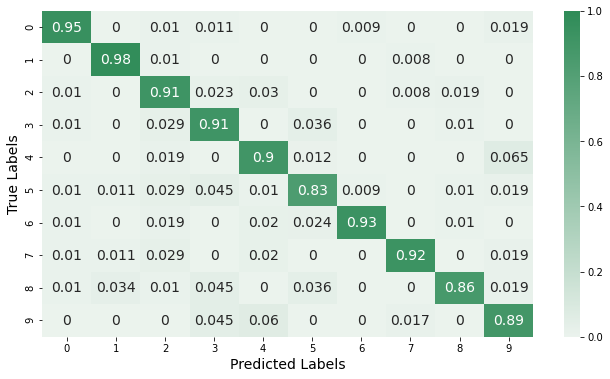

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.94845  0.93878   0.94359
1    1.0    0.97701  0.94444   0.96045
2    2.0    0.91429  0.85714   0.88479
3    3.0    0.90909  0.84211   0.87432
4    4.0    0.90000  0.86538   0.88235
5    5.0    0.83333  0.88608   0.85890
6    6.0    0.92727  0.98077   0.95327
7    7.0    0.92373  0.96460   0.94372
8    8.0    0.86538  0.94737   0.90452
9    9.0    0.88785  0.86364   0.87558



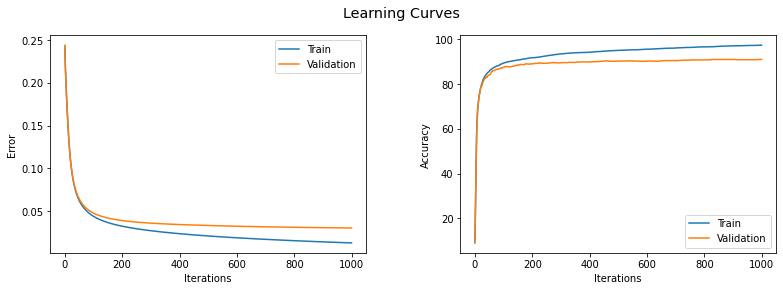

Accuracy

Accuracy on Train Set = 97.25%
Accuracy on Test Set = 90.9%



In [26]:
params_relu_gd, cost_relu_gd, cost_test_relu_gd, y_pred_relu_gd = NeuralNetwork(X_train, y_train,X_test,y_test,layers_relu,0.1,1000,activation_function = 'relu',optimizer = 'gd')

### 1.1.2  With L1 Regularization

Confusion Matrix :


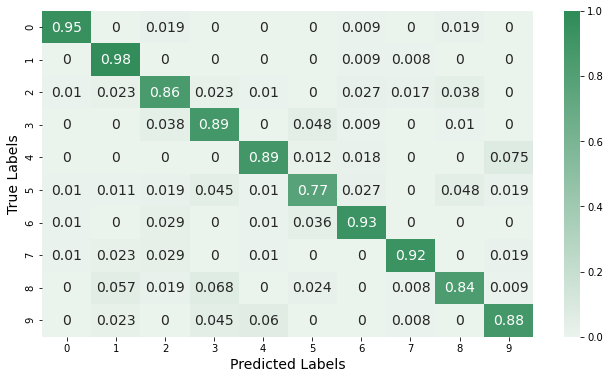

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.94845  0.95833   0.95336
1    1.0    0.97701  0.87629   0.92391
2    2.0    0.85714  0.84906   0.85308
3    3.0    0.88636  0.82979   0.85714
4    4.0    0.89000  0.89899   0.89447
5    5.0    0.77381  0.86667   0.81761
6    6.0    0.92727  0.90265   0.91479
7    7.0    0.92373  0.95614   0.93966
8    8.0    0.83654  0.87879   0.85714
9    9.0    0.87850  0.87850   0.87850



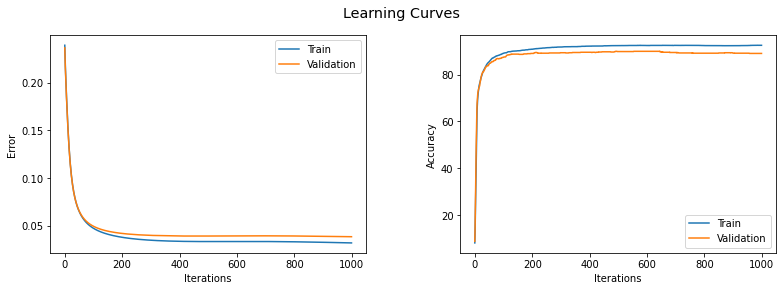

Accuracy

Accuracy on Train Set = 92.575%
Accuracy on Test Set = 89.1%



In [27]:
params_relu_gd_L1, cost_relu_gd_L1, cost_test_relu_gd_L1, y_pred_relu_gd_L1 = NeuralNetwork(X_train, y_train,X_test,y_test,layers_relu,0.1,1000,activation_function = 'relu',optimizer = 'gd',regularization = 'L1' , alpha = 0.001)

### 1.1.3  With L2 Regularization

Confusion Matrix :


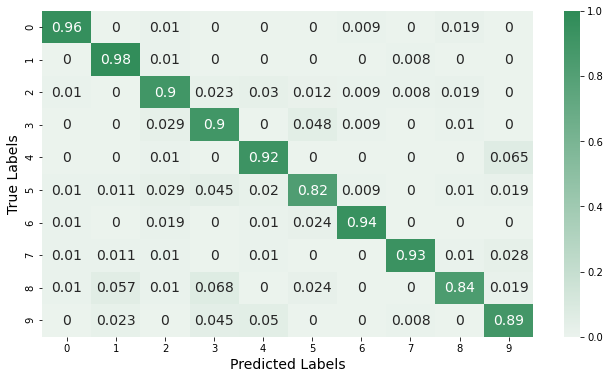

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.95876  0.94898   0.95384
1    1.0    0.97701  0.90426   0.93923
2    2.0    0.89524  0.87850   0.88679
3    3.0    0.89773  0.83158   0.86339
4    4.0    0.92000  0.88462   0.90196
5    5.0    0.82143  0.88462   0.85185
6    6.0    0.94545  0.96296   0.95412
7    7.0    0.93220  0.97345   0.95238
8    8.0    0.83654  0.92553   0.87879
9    9.0    0.88785  0.87156   0.87963



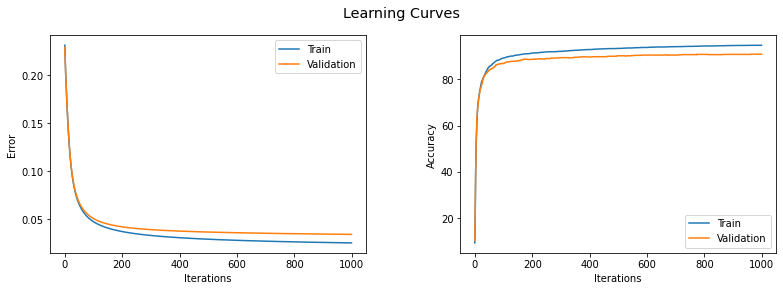

Accuracy

Accuracy on Train Set = 94.65%
Accuracy on Test Set = 90.8%



In [28]:
params_relu_gd_L2, cost_relu_gd_L2, cost_test_relu_gd_L2, y_pred_relu_gd_L2 = NeuralNetwork(X_train, y_train,X_test,y_test,layers_relu,0.1,1000,activation_function = 'relu',optimizer = 'gd',regularization = 'L2' , alpha = 0.01)

### 1.1.4  With Elastic Net Regularization

Confusion Matrix :


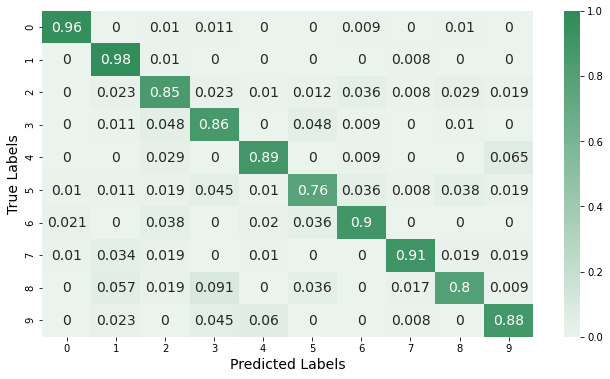

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.95876  0.95876   0.95876
1    1.0    0.97701  0.85859   0.91398
2    2.0    0.84762  0.81651   0.83177
3    3.0    0.86364  0.80000   0.83060
4    4.0    0.89000  0.89000   0.89000
5    5.0    0.76190  0.85333   0.80503
6    6.0    0.90000  0.90000   0.90000
7    7.0    0.90678  0.94690   0.92641
8    8.0    0.79808  0.88298   0.83839
9    9.0    0.87850  0.87037   0.87442



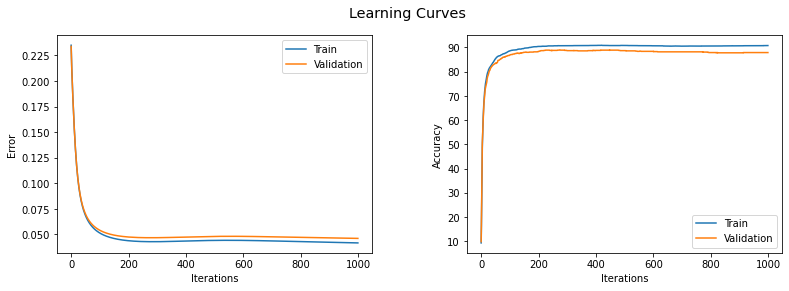

Accuracy

Accuracy on Train Set = 90.8%
Accuracy on Test Set = 87.9%



In [29]:
params_relu_gd_en, cost_relu_gd_en, cost_test_relu_gd_en, y_pred_relu_gd_en = NeuralNetwork(X_train, y_train,X_test,y_test,layers_relu,0.1,1000,activation_function = 'relu',optimizer = 'gd',regularization = 'elastic_net' , alpha = 0.001 , alpha2 = 0.01)

### 1.1.5  With Tikhonov Regularization

Confusion Matrix :


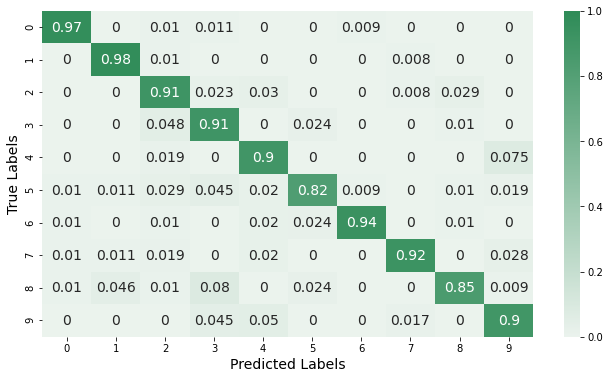

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.96907  0.95918   0.96410
1    1.0    0.97701  0.93407   0.95506
2    2.0    0.91429  0.85714   0.88479
3    3.0    0.90909  0.81633   0.86022
4    4.0    0.90000  0.86538   0.88235
5    5.0    0.82143  0.92000   0.86793
6    6.0    0.93636  0.98095   0.95814
7    7.0    0.92373  0.96460   0.94372
8    8.0    0.84615  0.93617   0.88889
9    9.0    0.89720  0.87273   0.88480



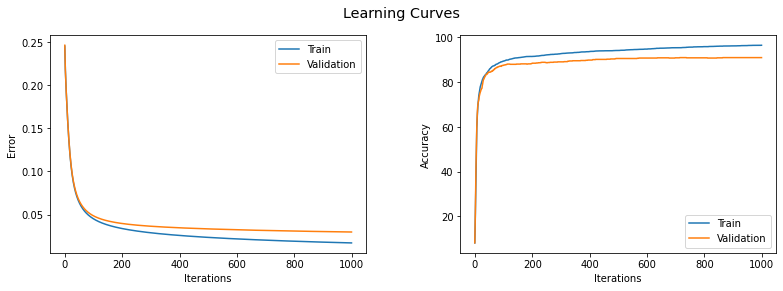

Accuracy

Accuracy on Train Set = 96.525%
Accuracy on Test Set = 91.0%



In [32]:
params_relu_gd_tkn, cost_relu_gd_tkn, cost_test_relu_gd_tkn, y_pred_relu_gd_tkn = NeuralNetwork(X_train, y_train,X_test,y_test,layers_relu,0.1,1000,activation_function = 'relu',optimizer = 'gd',regularization = 'L2_Tikhonov', alpha=0.01)

## 1.2  RMSprop Optimizer

Confusion Matrix :


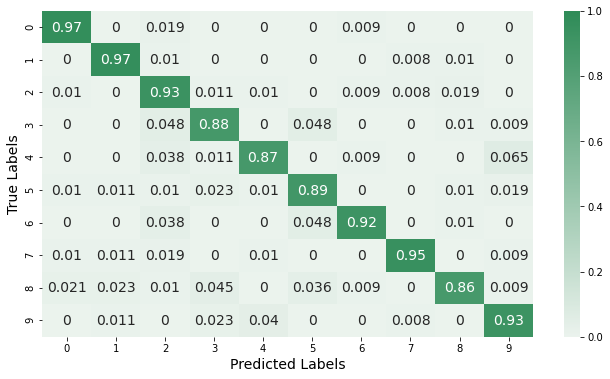

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.96907  0.94949   0.95918
1    1.0    0.96552  0.94382   0.95455
2    2.0    0.93333  0.83051   0.87892
3    3.0    0.87500  0.88506   0.88000
4    4.0    0.87000  0.92553   0.89691
5    5.0    0.89286  0.87209   0.88235
6    6.0    0.91818  0.96190   0.93953
7    7.0    0.94915  0.97391   0.96137
8    8.0    0.86538  0.93750   0.90000
9    9.0    0.92523  0.89189   0.90825



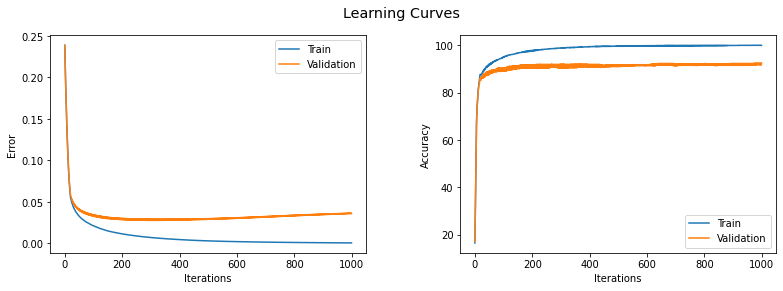

Accuracy

Accuracy on Train Set = 99.95%
Accuracy on Test Set = 91.7%



In [33]:
params_relu_rms, cost_relu_rms, cost_test_relu_rms, y_pred_relu_rms = NeuralNetwork(X_train, y_train,X_test,y_test,layers_relu,0.001,1000,activation_function = 'relu',optimizer = 'RMSProp',regularization = None , alpha = 0.001)

## 1.3  Adam Optimizer

Confusion Matrix :


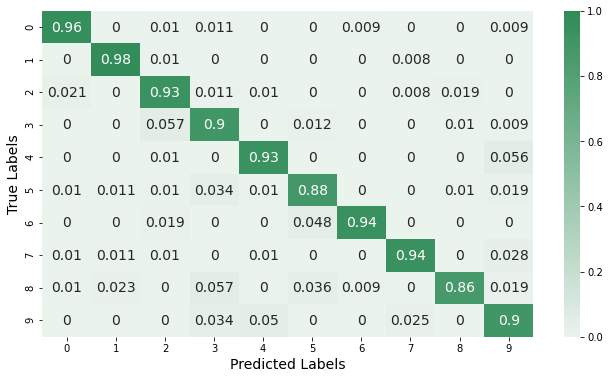

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.95876  0.94898   0.95384
1    1.0    0.97701  0.95506   0.96591
2    2.0    0.93333  0.88288   0.90740
3    3.0    0.89773  0.85870   0.87778
4    4.0    0.93000  0.92079   0.92537
5    5.0    0.88095  0.90244   0.89157
6    6.0    0.94545  0.98113   0.96296
7    7.0    0.94068  0.95690   0.94872
8    8.0    0.86538  0.95745   0.90909
9    9.0    0.89720  0.86486   0.88073



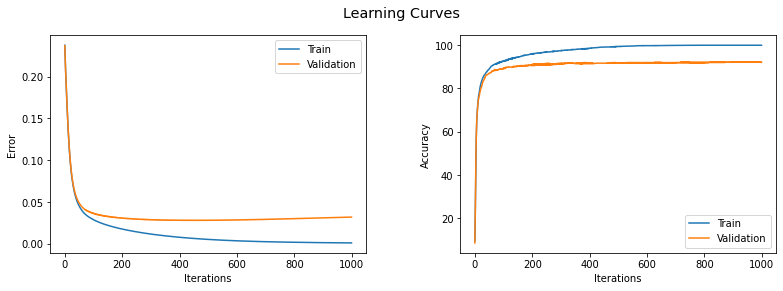

Accuracy

Accuracy on Train Set = 100.0%
Accuracy on Test Set = 92.3%



In [34]:
params_relu_adam, cost_relu_adam, cost_test_relu_adam, y_pred_relu_adam = NeuralNetwork(X_train, y_train,X_test,y_test,layers_relu,0.01,1000,activation_function = 'relu',optimizer = 'Adam',regularization = None , alpha = 0.1 , alpha2 = 0.01)

## 1.4  Momentum Optimizer

Confusion Matrix :


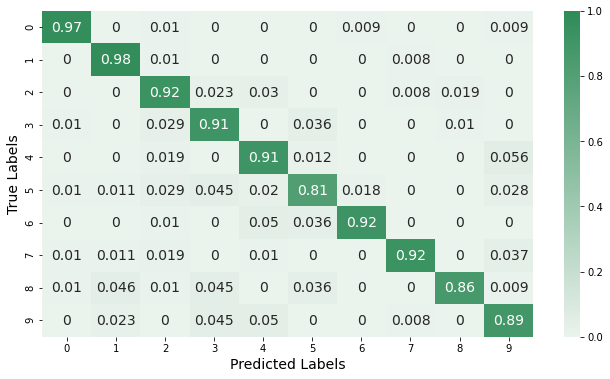

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.96907  0.95918   0.96410
1    1.0    0.97701  0.91398   0.94444
2    2.0    0.92381  0.87387   0.89815
3    3.0    0.90909  0.85106   0.87912
4    4.0    0.91000  0.85047   0.87923
5    5.0    0.80952  0.87179   0.83950
6    6.0    0.91818  0.97115   0.94392
7    7.0    0.92373  0.97321   0.94782
8    8.0    0.86538  0.96774   0.91370
9    9.0    0.88785  0.86364   0.87558



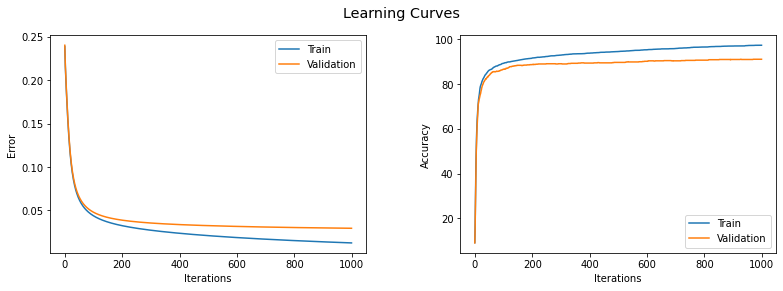

Accuracy

Accuracy on Train Set = 97.25%
Accuracy on Test Set = 91.0%



In [36]:
params_relu_mt, cost_relu_mt, cost_test_relu_mt, y_pred_relu_mt = NeuralNetwork(X_train, y_train,X_test,y_test,layers_relu,0.1,1000,activation_function = 'relu',optimizer = 'momentum',regularization = None , alpha = 0.01)

# 2  Tanh activation function

## 2.1  Gradient Descent

### 2.1.1  Without Regularization

In [37]:
layers_tanh = [784,128,10]

Confusion Matrix :


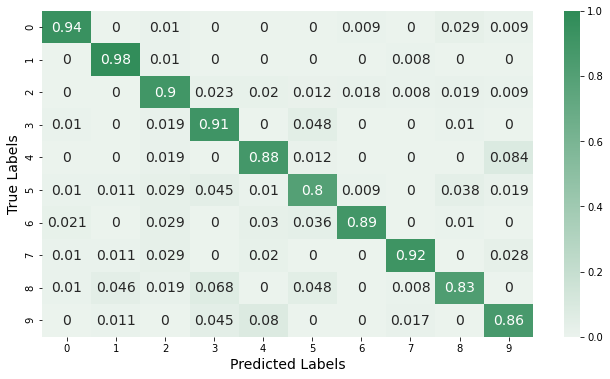

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.93814  0.93814   0.93814
1    1.0    0.97701  0.92391   0.94972
2    2.0    0.89524  0.84685   0.87037
3    3.0    0.90909  0.83333   0.86956
4    4.0    0.88000  0.84615   0.86274
5    5.0    0.79762  0.83750   0.81707
6    6.0    0.89091  0.96078   0.92453
7    7.0    0.91525  0.95575   0.93506
8    8.0    0.82692  0.88660   0.85572
9    9.0    0.85981  0.85185   0.85581



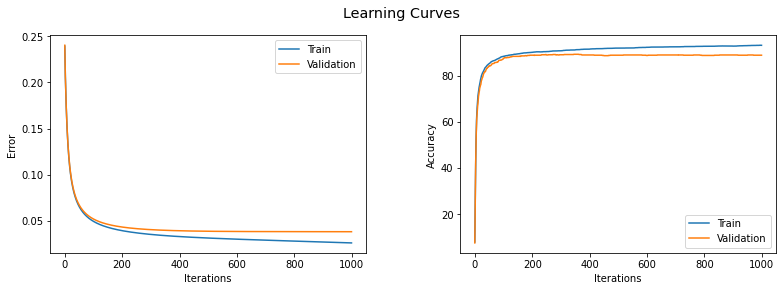

Accuracy

Accuracy on Train Set = 93.2%
Accuracy on Test Set = 88.9%



In [38]:
params_tanh_gd, cost_tanh_gd, cost_test_tanh_gd, y_pred_tanh_gd = NeuralNetwork(X_train, y_train,X_test,y_test,layers_tanh,0.1,1000,activation_function = 'tanh',optimizer = 'gd')

### 2.1.2  With L1 Regularization

Confusion Matrix :


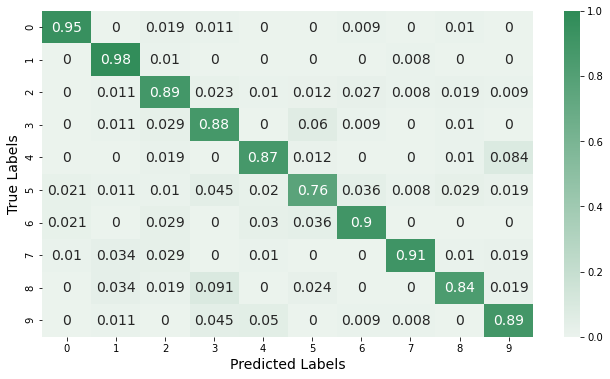

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.94845  0.94845   0.94845
1    1.0    0.97701  0.89474   0.93407
2    2.0    0.88571  0.84545   0.86511
3    3.0    0.87500  0.80208   0.83695
4    4.0    0.87000  0.87879   0.87437
5    5.0    0.76190  0.84211   0.80000
6    6.0    0.90000  0.90826   0.90411
7    7.0    0.90678  0.96396   0.93450
8    8.0    0.83654  0.90625   0.87000
9    9.0    0.88785  0.85586   0.87156



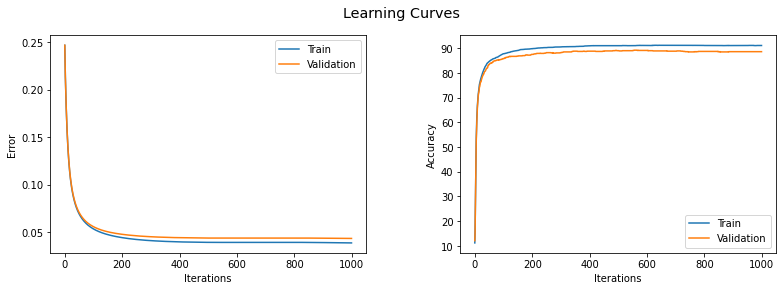

Accuracy

Accuracy on Train Set = 91.1%
Accuracy on Test Set = 88.6%



In [39]:
params_tanh_gd_L1, cost_tanh_gd_L1, cost_test_tanh_gd_L1, y_pred_tanh_gd_L1 = NeuralNetwork(X_train, y_train,X_test,y_test,layers_tanh,0.1,1000,activation_function = 'tanh',optimizer = 'gd',regularization = 'L1' , alpha = 0.001)

### 2.1.3  With L2 Regularization

Confusion Matrix :


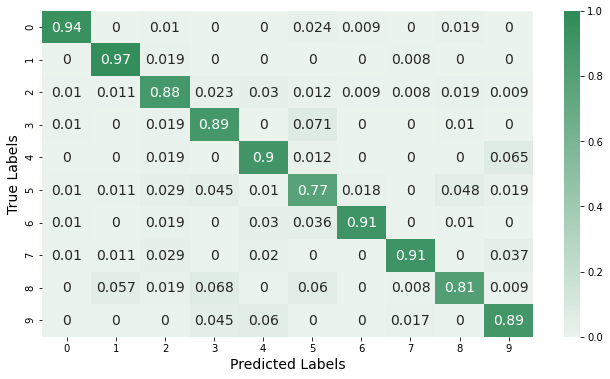

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.93814  0.94792   0.94300
1    1.0    0.96552  0.91304   0.93855
2    2.0    0.87619  0.84404   0.85981
3    3.0    0.88636  0.82979   0.85714
4    4.0    0.90000  0.85714   0.87805
5    5.0    0.77381  0.78313   0.77844
6    6.0    0.90909  0.96154   0.93458
7    7.0    0.90678  0.95536   0.93044
8    8.0    0.80769  0.88421   0.84422
9    9.0    0.88785  0.86364   0.87558



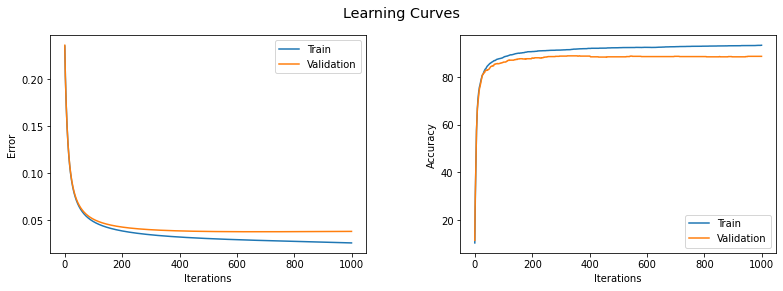

Accuracy

Accuracy on Train Set = 93.25%
Accuracy on Test Set = 88.6%



In [40]:
params_tanh_gd_L2, cost_tanh_gd_L2, cost_test_tanh_gd_L2, y_pred_tanh_gd_L2 = NeuralNetwork(X_train, y_train,X_test,y_test,layers_tanh,0.1,1000,activation_function = 'tanh',optimizer = 'gd',regularization = 'L2' , alpha = 0.0001)

### 2.1.4  With Elastic Net Regularization

Confusion Matrix :


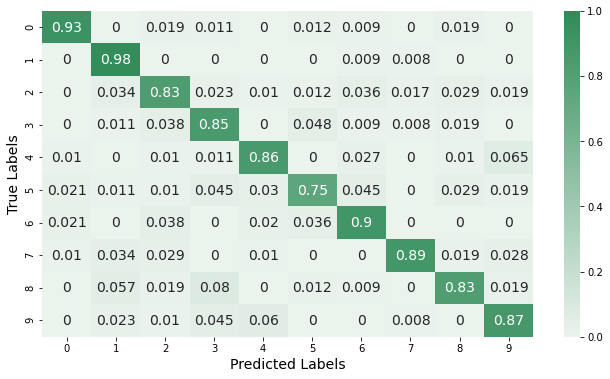

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.92784  0.93750   0.93264
1    1.0    0.97701  0.85000   0.90909
2    2.0    0.82857  0.82857   0.82857
3    3.0    0.85227  0.79787   0.82417
4    4.0    0.86000  0.86869   0.86432
5    5.0    0.75000  0.86301   0.80255
6    6.0    0.90000  0.86087   0.88000
7    7.0    0.88983  0.95455   0.92105
8    8.0    0.82692  0.86869   0.84729
9    9.0    0.86916  0.85321   0.86111



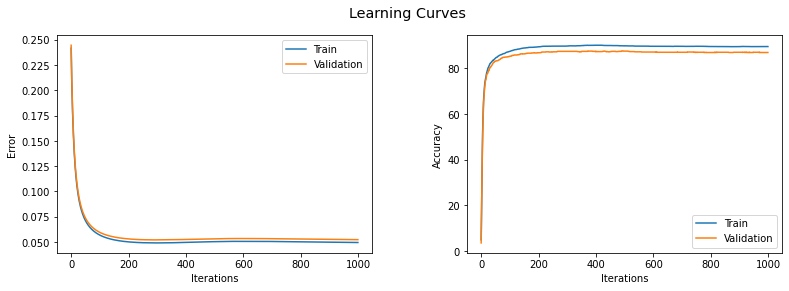

Accuracy

Accuracy on Train Set = 89.5%
Accuracy on Test Set = 86.9%



In [41]:
params_tanh_gd_en, cost_tanh_gd_en, cost_test_tanh_gd_en, y_pred_tanh_gd_en = NeuralNetwork(X_train, y_train,X_test,y_test,layers_tanh,0.1,1000,activation_function = 'tanh',optimizer = 'gd',regularization = 'elastic_net' , alpha = 0.001, alpha2 = 0.01)

### 2.1.5  With Tikhonov Regularization

Confusion Matrix :


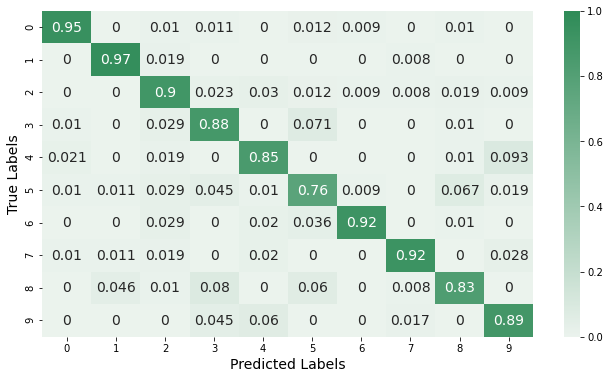

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.94845  0.94845   0.94845
1    1.0    0.96552  0.93333   0.94915
2    2.0    0.89524  0.84685   0.87037
3    3.0    0.87500  0.81053   0.84153
4    4.0    0.85000  0.85859   0.85427
5    5.0    0.76190  0.80000   0.78049
6    6.0    0.91818  0.97115   0.94392
7    7.0    0.92373  0.95614   0.93966
8    8.0    0.82692  0.86869   0.84729
9    9.0    0.88785  0.85586   0.87156



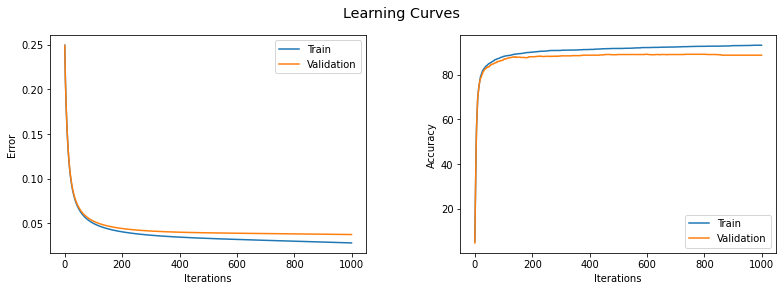

Accuracy

Accuracy on Train Set = 93.15%
Accuracy on Test Set = 88.7%



In [42]:
params_tanh_gd_tkn, cost_tanh_gd_tkn, cost_test_tanh_gd_tkn, y_pred_tanh_gd_tkn = NeuralNetwork(X_train, y_train,X_test,y_test,layers_tanh,0.1,1000,activation_function = 'tanh',optimizer = 'gd',regularization = 'L2_Tikhonov',alpha=0.01)

## 2.2  RMSprop Optimizer

Confusion Matrix :


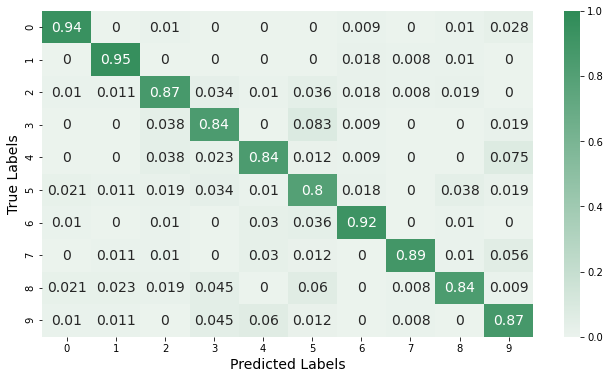

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.93814  0.92857   0.93333
1    1.0    0.95402  0.93258   0.94318
2    2.0    0.86667  0.85849   0.86256
3    3.0    0.84091  0.82222   0.83146
4    4.0    0.84000  0.85714   0.84848
5    5.0    0.79762  0.76136   0.77907
6    6.0    0.91818  0.91818   0.91818
7    7.0    0.88983  0.96330   0.92511
8    8.0    0.83654  0.89691   0.86567
9    9.0    0.86916  0.80870   0.83784



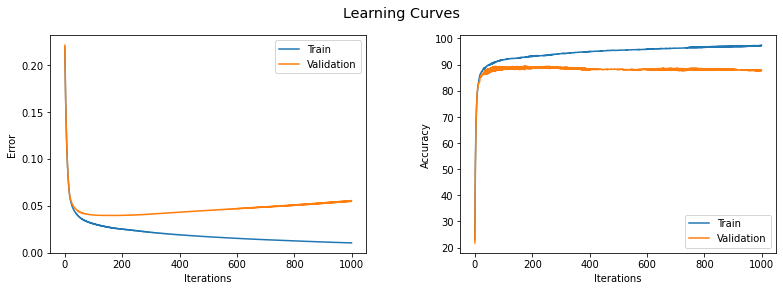

Accuracy

Accuracy on Train Set = 97.4%
Accuracy on Test Set = 87.6%



In [43]:
params_tanh_rms, cost_tanh_rms, cost_test_tanh_rms, y_pred_tanh_rms = NeuralNetwork(X_train, y_train,X_test,y_test,layers_tanh,0.001,1000,activation_function = 'tanh',optimizer = 'RMSProp',regularization = None , alpha = 0.01)

## 2.3  Adam Optimizer

Confusion Matrix :


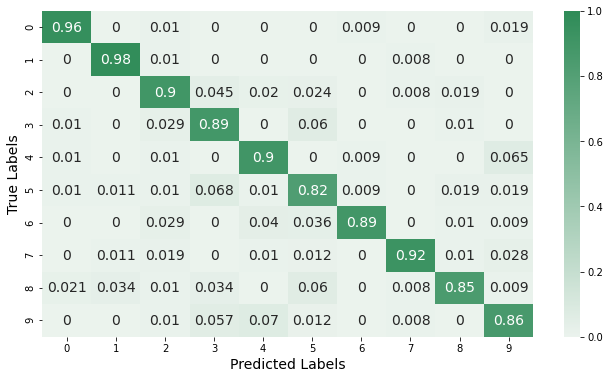

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.95876  0.94898   0.95384
1    1.0    0.97701  0.94444   0.96045
2    2.0    0.89524  0.87037   0.88263
3    3.0    0.88636  0.81250   0.84782
4    4.0    0.90000  0.85714   0.87805
5    5.0    0.82143  0.80233   0.81177
6    6.0    0.89091  0.97030   0.92891
7    7.0    0.92373  0.96460   0.94372
8    8.0    0.84615  0.92632   0.88442
9    9.0    0.85981  0.85185   0.85581



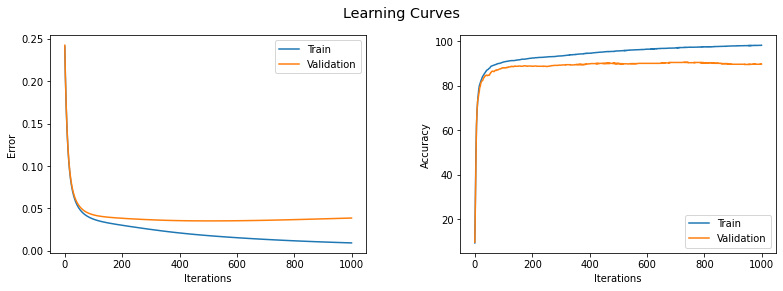

Accuracy

Accuracy on Train Set = 98.125%
Accuracy on Test Set = 89.6%



In [44]:
params_tanh_adam, cost_tanh_adam, cost_test_tanh_adam, y_pred_tanh_adam = NeuralNetwork(X_train, y_train,X_test,y_test,layers_tanh,0.01,1000,activation_function = 'tanh',optimizer = 'Adam',regularization = None , alpha = 0.1 , alpha2 = 0.01)

## 2.4  Momentum Optimizer

Confusion Matrix :


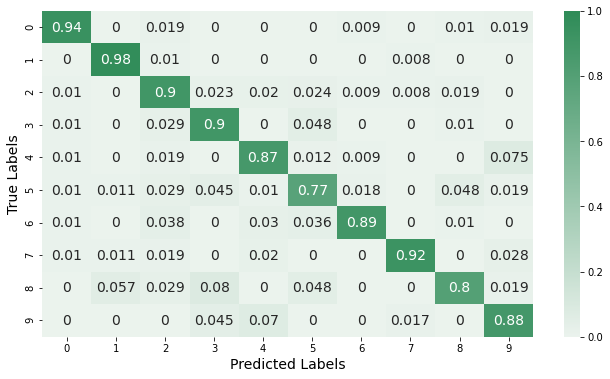

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.93814  0.93814   0.93814
1    1.0    0.97701  0.92391   0.94972
2    2.0    0.89524  0.82456   0.85845
3    3.0    0.89773  0.82292   0.85870
4    4.0    0.87000  0.85294   0.86139
5    5.0    0.77381  0.82278   0.79754
6    6.0    0.89091  0.95146   0.92019
7    7.0    0.92373  0.96460   0.94372
8    8.0    0.79808  0.89247   0.84264
9    9.0    0.87850  0.84685   0.86238



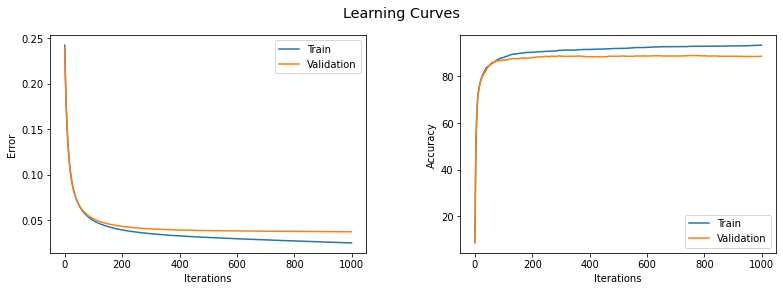

Accuracy

Accuracy on Train Set = 93.2%
Accuracy on Test Set = 88.5%



In [45]:
params_tanh_mt, cost_tanh_mt, cost_test_tanh_mt, y_pred_tanh_mt = NeuralNetwork(X_train, y_train,X_test,y_test,layers_tanh,0.1,1000,activation_function = 'tanh',optimizer = 'momentum',regularization = None , alpha = 0.01)

# 3  Sigmoid activation function

## 3.1  Gradient Descent

### 3.1.1  Without Regularization

In [63]:
layers_sig = [784,128,10]

Confusion Matrix :


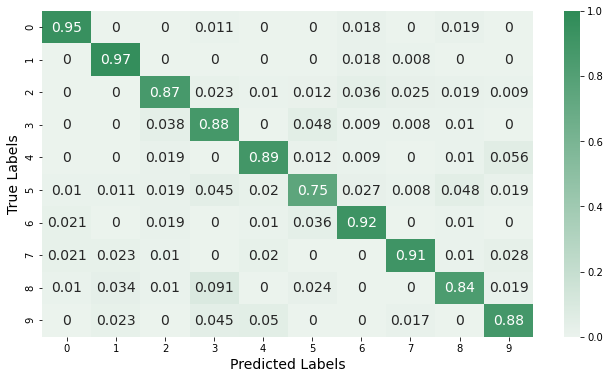

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.94845  0.93878   0.94359
1    1.0    0.96552  0.91304   0.93855
2    2.0    0.86667  0.88350   0.87500
3    3.0    0.87500  0.80208   0.83695
4    4.0    0.89000  0.89000   0.89000
5    5.0    0.75000  0.85135   0.79747
6    6.0    0.91818  0.88596   0.90178
7    7.0    0.90678  0.93043   0.91845
8    8.0    0.83654  0.87000   0.85294
9    9.0    0.87850  0.87037   0.87442



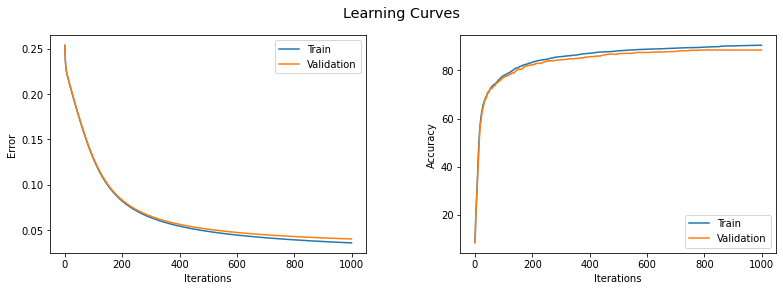

Accuracy

Accuracy on Train Set = 90.5%
Accuracy on Test Set = 88.5%



In [64]:
params_sig_gd, cost_sig_gd, cost_test_sig_gd, y_pred_sig_gd = NeuralNetwork(X_train, y_train,X_test,y_test,layers_sig,0.1,1000,activation_function = 'sigmoid',optimizer = 'gd')

### 3.1.2  With L1 Regularization

Confusion Matrix :


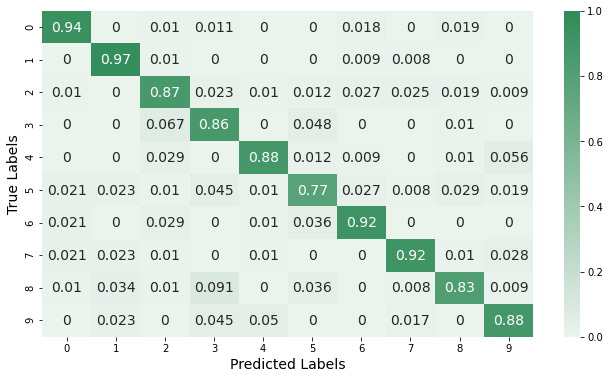

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.93814  0.91919   0.92857
1    1.0    0.96552  0.90323   0.93334
2    2.0    0.86667  0.83486   0.85047
3    3.0    0.86364  0.80000   0.83060
4    4.0    0.88000  0.90722   0.89340
5    5.0    0.77381  0.84416   0.80746
6    6.0    0.91818  0.90991   0.91403
7    7.0    0.91525  0.93103   0.92307
8    8.0    0.82692  0.89583   0.86000
9    9.0    0.87850  0.87850   0.87850



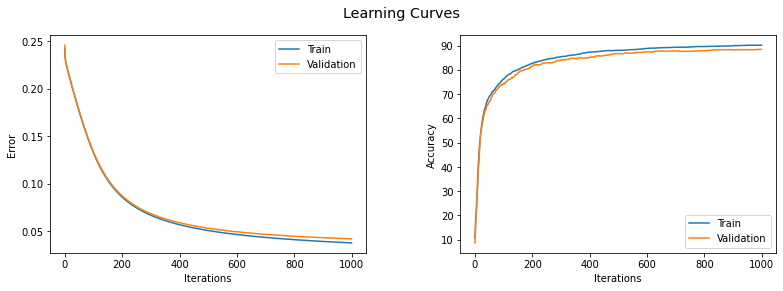

Accuracy

Accuracy on Train Set = 90.125%
Accuracy on Test Set = 88.4%



In [65]:
params_sig_gd_L1, cost_sig_gd_L1, cost_test_sig_gd_L1, y_pred_sig_gd_L1 = NeuralNetwork(X_train, y_train,X_test,y_test,layers_sig,0.1,1000,activation_function = 'sigmoid',optimizer = 'gd',regularization = 'L1' , alpha = 0.0001)

### 3.1.3  With L2 Regularization

Confusion Matrix :


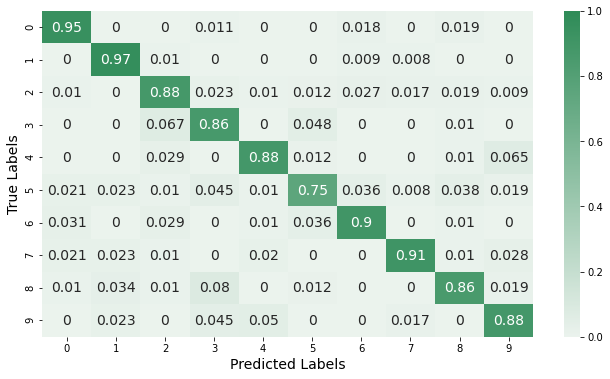

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.94845  0.91089   0.92929
1    1.0    0.96552  0.90323   0.93334
2    2.0    0.87619  0.84404   0.85981
3    3.0    0.86364  0.80851   0.83517
4    4.0    0.88000  0.89796   0.88889
5    5.0    0.75000  0.86301   0.80255
6    6.0    0.90000  0.90826   0.90411
7    7.0    0.90678  0.94690   0.92641
8    8.0    0.85577  0.88119   0.86829
9    9.0    0.87850  0.86239   0.87037



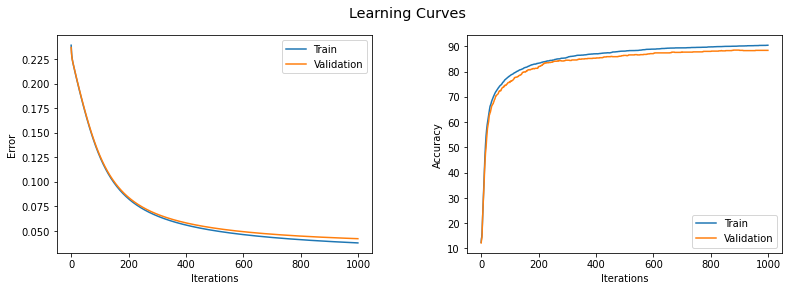

Accuracy

Accuracy on Train Set = 90.425%
Accuracy on Test Set = 88.4%



In [66]:
params_sig_gd_L2, cost_sig_gd_L2, cost_test_sig_gd_L2, y_pred_sig_gd_L2 = NeuralNetwork(X_train, y_train,X_test,y_test,layers_sig,0.1,1000,activation_function = 'sigmoid',optimizer = 'gd',regularization = 'L2' , alpha = 0.001)

### 3.1.4  With Elastic Net Regularization

Confusion Matrix :


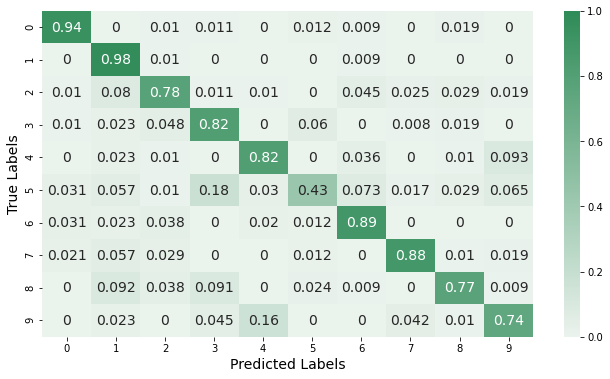

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.93814  0.90099   0.91919
1    1.0    0.97701  0.72034   0.82927
2    2.0    0.78095  0.80392   0.79227
3    3.0    0.81818  0.70588   0.75789
4    4.0    0.82000  0.78846   0.80392
5    5.0    0.42857  0.78261   0.55385
6    6.0    0.89091  0.83051   0.85965
7    7.0    0.88136  0.90435   0.89271
8    8.0    0.76923  0.86022   0.81218
9    9.0    0.73832  0.78218   0.75962



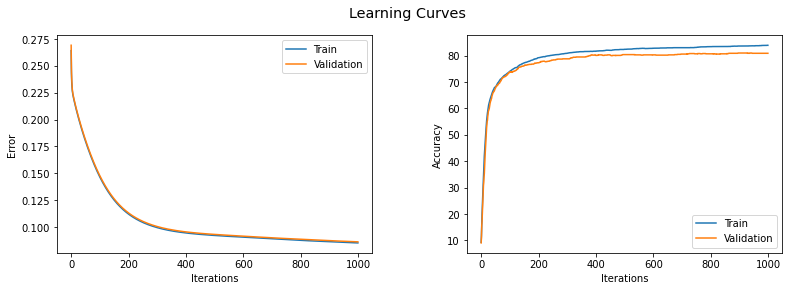

Accuracy

Accuracy on Train Set = 83.925%
Accuracy on Test Set = 80.9%



In [69]:
params_sig_gd_en, cost_sig_gd_en, cost_test_sig_gd_en, y_pred_sig_gd_en = NeuralNetwork(X_train, y_train,X_test,y_test,layers_sig,0.1,1000,activation_function = 'sigmoid',optimizer = 'gd',regularization = 'elastic_net' , alpha = 0.001, alpha2 = 0.01)

### 3.1.5  With Tikhonov Regularization

Confusion Matrix :


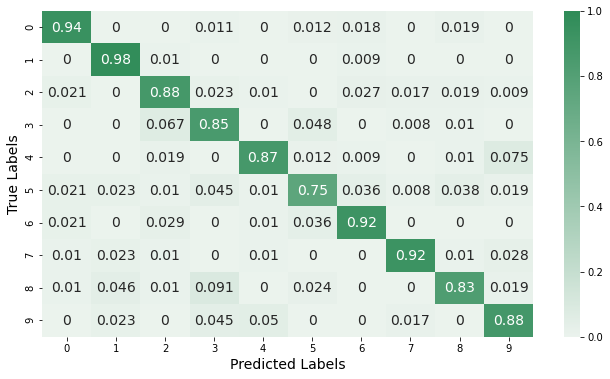

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.93814  0.91919   0.92857
1    1.0    0.97701  0.89474   0.93407
2    2.0    0.87619  0.85185   0.86385
3    3.0    0.85227  0.79787   0.82417
4    4.0    0.87000  0.90625   0.88776
5    5.0    0.75000  0.85135   0.79747
6    6.0    0.91818  0.90179   0.90991
7    7.0    0.92373  0.94783   0.93562
8    8.0    0.82692  0.88660   0.85572
9    9.0    0.87850  0.85455   0.86636



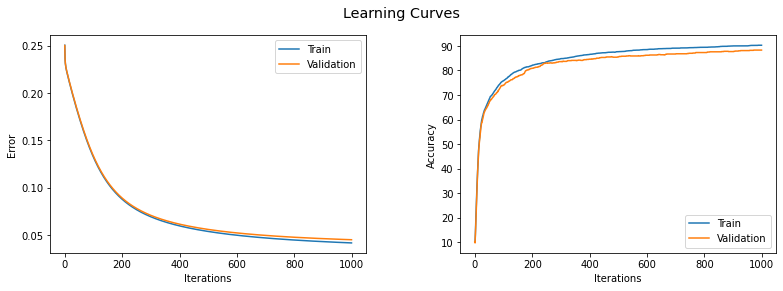

Accuracy

Accuracy on Train Set = 90.275%
Accuracy on Test Set = 88.3%



In [70]:
params_sig_gd_tkn, cost_sig_gd_tkn, cost_test_sig_gd_tkn, y_pred_sig_gd_tkn = NeuralNetwork(X_train, y_train,X_test,y_test,layers_sig,0.1,1000,activation_function = 'sigmoid',optimizer = 'gd',regularization = 'L2_Tikhonov', alpha=0.01)

## 3.2  RMSprop Optimizer

Confusion Matrix :


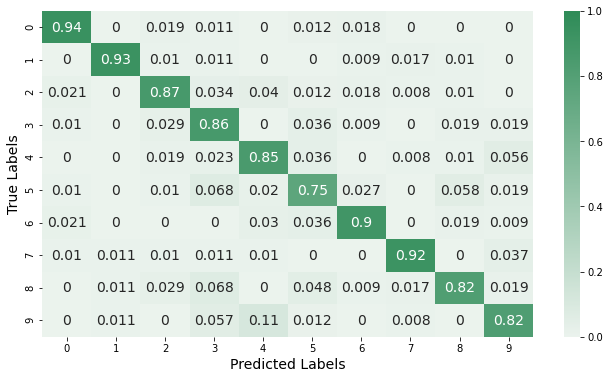

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.93814  0.92857   0.93333
1    1.0    0.93103  0.96429   0.94737
2    2.0    0.86667  0.87500   0.87082
3    3.0    0.86364  0.75248   0.80424
4    4.0    0.85000  0.80189   0.82524
5    5.0    0.75000  0.79747   0.77301
6    6.0    0.90000  0.90826   0.90411
7    7.0    0.92373  0.93966   0.93163
8    8.0    0.81731  0.86735   0.84159
9    9.0    0.82243  0.83810   0.83019



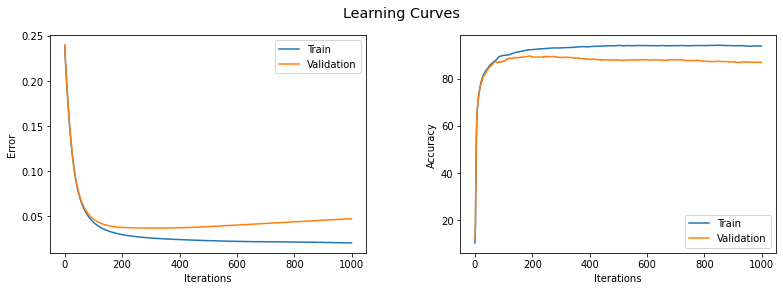

Accuracy

Accuracy on Train Set = 93.925%
Accuracy on Test Set = 86.8%



In [71]:
params_sig_rms, cost_sig_rms, cost_test_sig_rms, y_pred_sig_rms = NeuralNetwork(X_train, y_train,X_test,y_test,layers_sig,0.001,1000,activation_function = 'sigmoid',optimizer = 'RMSProp',regularization = None , alpha = 0.01)

## 3.3  Adam Optimizer

Confusion Matrix :


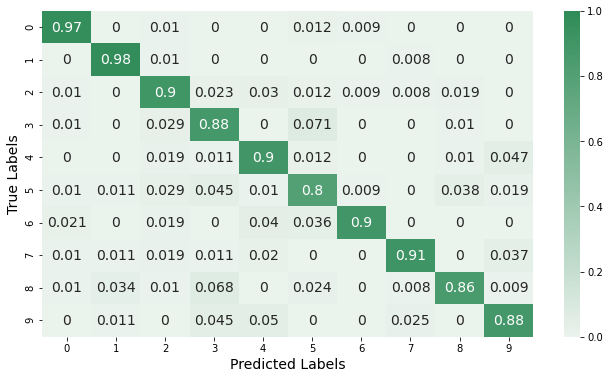

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.96907  0.93069   0.94949
1    1.0    0.97701  0.93407   0.95506
2    2.0    0.89524  0.86239   0.87851
3    3.0    0.87500  0.81053   0.84153
4    4.0    0.90000  0.85714   0.87805
5    5.0    0.79762  0.82716   0.81212
6    6.0    0.90000  0.97059   0.93396
7    7.0    0.90678  0.94690   0.92641
8    8.0    0.85577  0.91753   0.88557
9    9.0    0.87850  0.88679   0.88263



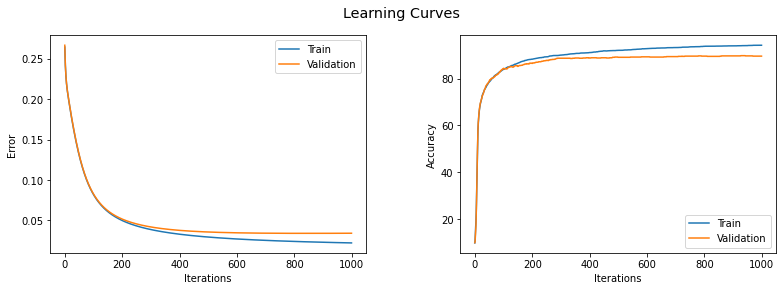

Accuracy

Accuracy on Train Set = 94.25%
Accuracy on Test Set = 89.6%



In [68]:
params_sig_adam, cost_sig_adam, cost_test_sig_adam, y_pred_sig_adam = NeuralNetwork(X_train, y_train,X_test,y_test,layers_tanh,0.01,1000,activation_function = 'sigmoid',optimizer = 'Adam',regularization = None , alpha = 0.1 , alpha2 = 0.01)

## 3.4  Momentum Optimizer

Confusion Matrix :


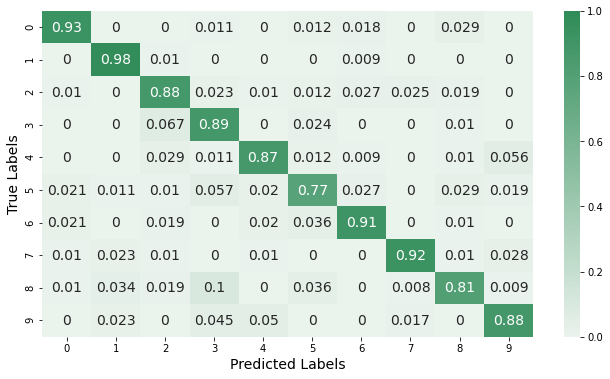

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.92784  0.92784   0.92784
1    1.0    0.97701  0.91398   0.94444
2    2.0    0.87619  0.84404   0.85981
3    3.0    0.88636  0.78000   0.82979
4    4.0    0.87000  0.88776   0.87879
5    5.0    0.77381  0.85526   0.81250
6    6.0    0.90909  0.90909   0.90909
7    7.0    0.92373  0.94783   0.93562
8    8.0    0.80769  0.87500   0.84000
9    9.0    0.87850  0.88679   0.88263



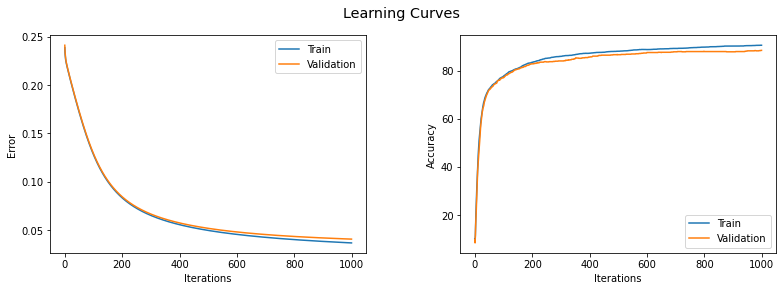

Accuracy

Accuracy on Train Set = 90.525%
Accuracy on Test Set = 88.4%



In [67]:
params_sig_mt, cost_sig_mt, cost_test_sig_mt, y_pred_sig_mt = NeuralNetwork(X_train, y_train,X_test,y_test,layers_sig,0.1,1000,activation_function = 'sigmoid',optimizer = 'momentum',regularization = None , alpha = 0.01)

# 4  Leaky ReLU activation function

## 4.1  Gradient Descent

### 4.1.1  Without Regularization

In [46]:
layers_lr = [784,128,10]

Confusion Matrix :


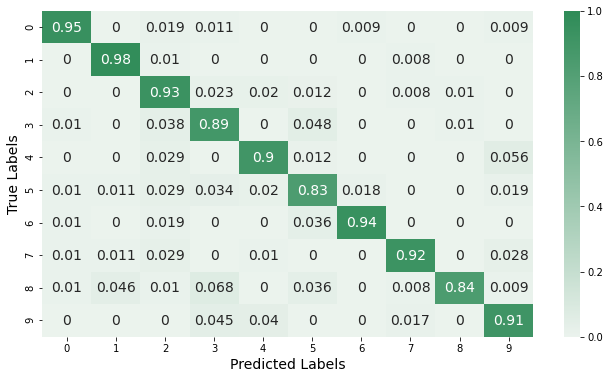

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.94845  0.94845   0.94845
1    1.0    0.97701  0.93407   0.95506
2    2.0    0.93333  0.83761   0.88288
3    3.0    0.88636  0.82979   0.85714
4    4.0    0.90000  0.90909   0.90452
5    5.0    0.83333  0.85366   0.84337
6    6.0    0.94545  0.97196   0.95852
7    7.0    0.92373  0.95614   0.93966
8    8.0    0.83654  0.97753   0.90156
9    9.0    0.90654  0.88182   0.89401



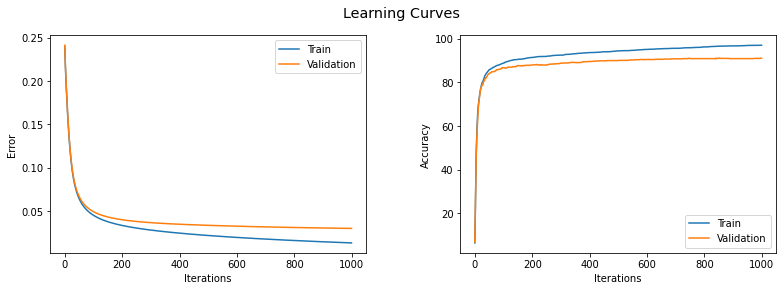

Accuracy

Accuracy on Train Set = 96.925%
Accuracy on Test Set = 91.0%



In [47]:
params_lr_gd, cost_lr_gd, cost_test_lr_gd, y_pred_lr_gd = NeuralNetwork(X_train, y_train,X_test,y_test,layers_lr,0.1,1000,activation_function = 'leaky_relu',optimizer = 'gd')

### 4.1.2  With L1 Regularization

Confusion Matrix :


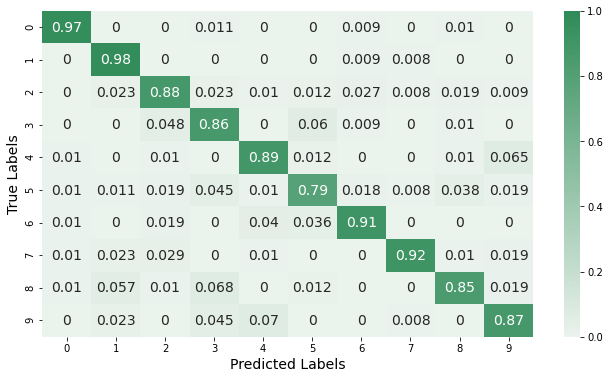

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.96907  0.94949   0.95918
1    1.0    0.97701  0.87629   0.92391
2    2.0    0.87619  0.86792   0.87204
3    3.0    0.86364  0.81720   0.83978
4    4.0    0.89000  0.86408   0.87685
5    5.0    0.78571  0.85714   0.81987
6    6.0    0.90909  0.92593   0.91743
7    7.0    0.91525  0.96429   0.93913
8    8.0    0.84615  0.89796   0.87129
9    9.0    0.86916  0.86916   0.86916



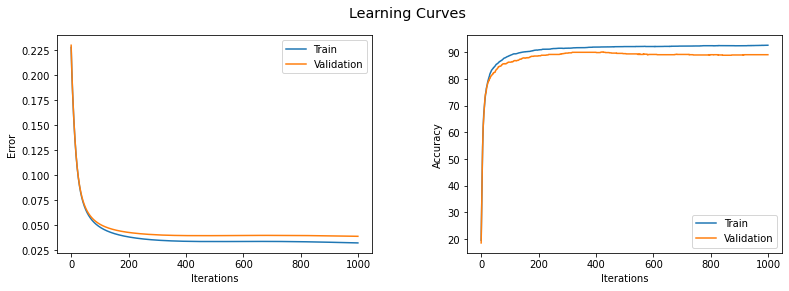

Accuracy

Accuracy on Train Set = 92.65%
Accuracy on Test Set = 89.1%



In [57]:
params_lr_gd_L1, cost_lr_gd_L1, cost_test_lr_gd_L1, y_pred_lr_gd_L1 = NeuralNetwork(X_train, y_train,X_test,y_test,layers_lr,0.1,1000,activation_function = 'leaky_relu',optimizer = 'gd',regularization = 'L1' , alpha = 0.001)

### 4.1.3  With L2 Regularization

Confusion Matrix :


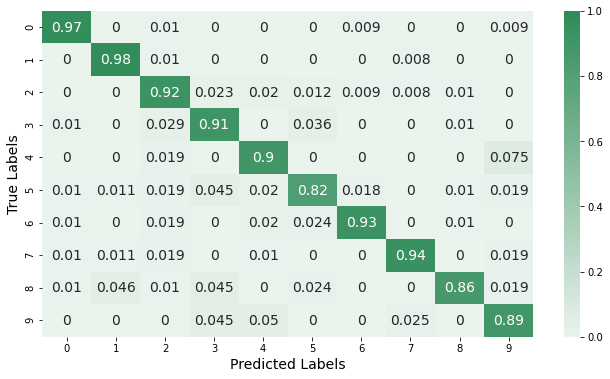

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.96907  0.94949   0.95918
1    1.0    0.97701  0.93407   0.95506
2    2.0    0.92381  0.87387   0.89815
3    3.0    0.90909  0.85106   0.87912
4    4.0    0.90000  0.88235   0.89109
5    5.0    0.82143  0.89610   0.85714
6    6.0    0.92727  0.96226   0.94444
7    7.0    0.94068  0.95690   0.94872
8    8.0    0.86538  0.95745   0.90909
9    9.0    0.88785  0.86364   0.87558



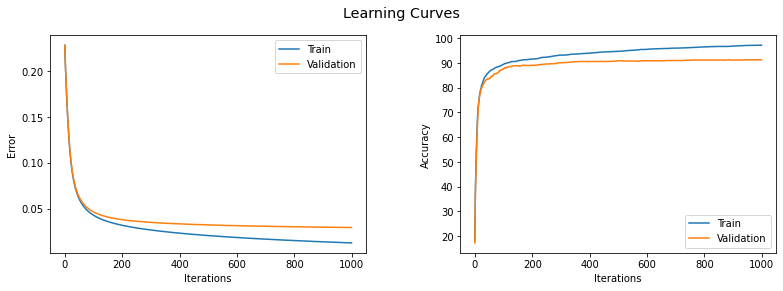

Accuracy

Accuracy on Train Set = 97.175%
Accuracy on Test Set = 91.3%



In [59]:
params_lr_gd_L2, cost_lr_gd_L2, cost_test_lr_gd_L2, y_pred_lr_gd_L2 = NeuralNetwork(X_train, y_train,X_test,y_test,layers_lr,0.1,1000,activation_function = 'leaky_relu',optimizer = 'gd',regularization = 'L2' , alpha = 0.0001)

### 4.1.4  With Elastic Net Regularization

Confusion Matrix :


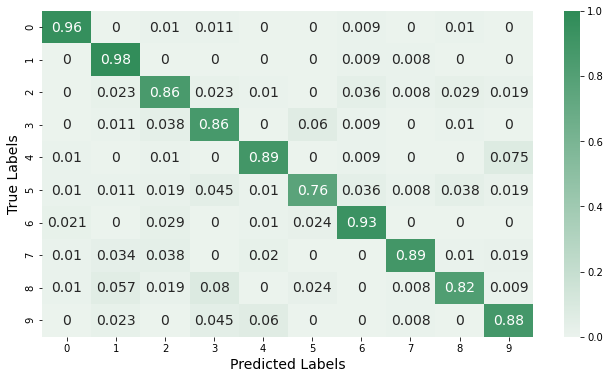

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.95876  0.93939   0.94898
1    1.0    0.97701  0.85859   0.91398
2    2.0    0.85714  0.84112   0.84905
3    3.0    0.86364  0.80851   0.83517
4    4.0    0.89000  0.89000   0.89000
5    5.0    0.76190  0.87671   0.81528
6    6.0    0.92727  0.89474   0.91071
7    7.0    0.88983  0.95455   0.92105
8    8.0    0.81731  0.89474   0.85427
9    9.0    0.87850  0.86239   0.87037



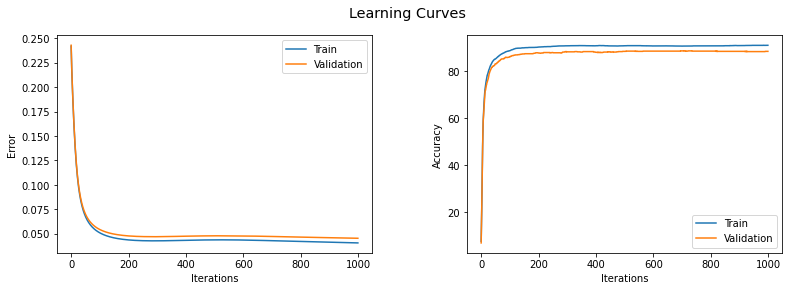

Accuracy

Accuracy on Train Set = 90.875%
Accuracy on Test Set = 88.3%



In [61]:
params_lr_gd_en, cost_lr_gd_en, cost_test_lr_gd_en, y_pred_lr_gd_en = NeuralNetwork(X_train, y_train,X_test,y_test,layers_lr,0.1,1000,activation_function = 'leaky_relu',optimizer = 'gd',regularization = 'elastic_net' , alpha = 0.001, alpha2 = 0.01)

### 4.1.5  With Tikhonov Regularization

Confusion Matrix :


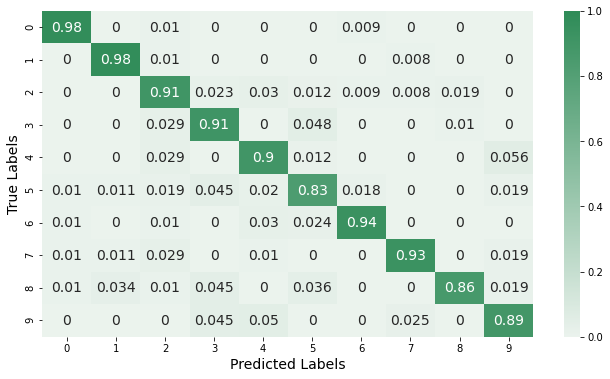

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.97938  0.95960   0.96939
1    1.0    0.97701  0.94444   0.96045
2    2.0    0.90476  0.86364   0.88372
3    3.0    0.90909  0.85106   0.87912
4    4.0    0.90000  0.86538   0.88235
5    5.0    0.83333  0.86420   0.84848
6    6.0    0.93636  0.96262   0.94931
7    7.0    0.93220  0.95652   0.94420
8    8.0    0.86538  0.96774   0.91370
9    9.0    0.88785  0.88785   0.88785



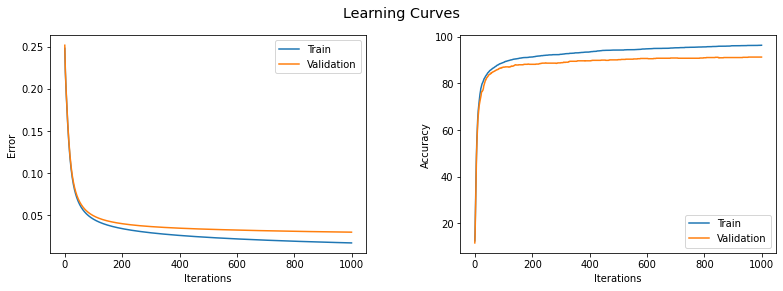

Accuracy

Accuracy on Train Set = 96.375%
Accuracy on Test Set = 91.3%



In [62]:
params_lr_gd_tkn, cost_lr_gd_tkn, cost_test_lr_gd_tkn, y_pred_lr_gd_tkn = NeuralNetwork(X_train, y_train,X_test,y_test,layers_lr,0.1,1000,activation_function = 'leaky_relu',optimizer = 'gd',regularization = 'L2_Tikhonov', alpha=0.01)

## 4.2  RMSprop Optimizer

Confusion Matrix :


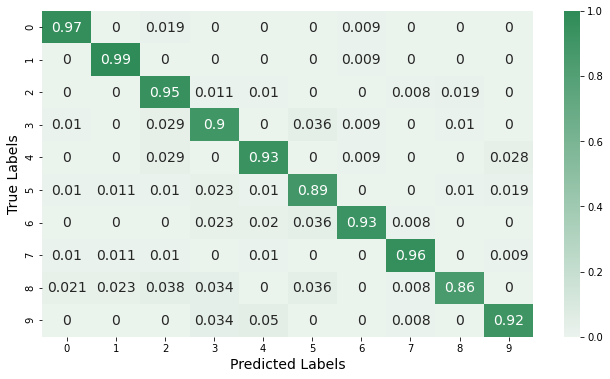

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.96907  0.94949   0.95918
1    1.0    0.98851  0.95556   0.97176
2    2.0    0.95238  0.87719   0.91324
3    3.0    0.89773  0.87778   0.88764
4    4.0    0.93000  0.90291   0.91625
5    5.0    0.89286  0.89286   0.89286
6    6.0    0.92727  0.96226   0.94444
7    7.0    0.95763  0.96581   0.96170
8    8.0    0.85577  0.95699   0.90355
9    9.0    0.91589  0.94231   0.92891



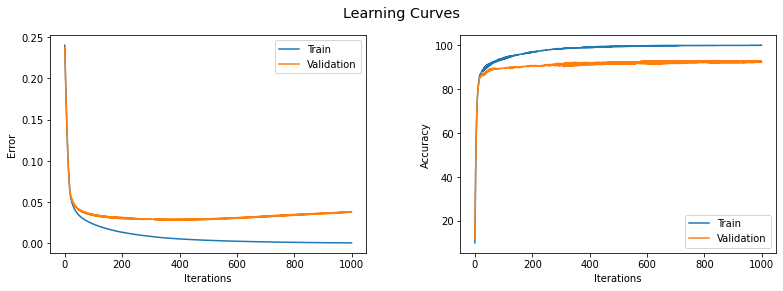

Accuracy

Accuracy on Train Set = 100.0%
Accuracy on Test Set = 92.9%



In [53]:
params_lr_rms, cost_lr_rms, cost_test_lr_rms, y_pred_lr_rms = NeuralNetwork(X_train, y_train,X_test,y_test,layers_lr,0.001,1000,activation_function = 'leaky_relu',optimizer = 'RMSProp',regularization = None , alpha = 0.01)

## 4.3  Adam Optimizer

Confusion Matrix :


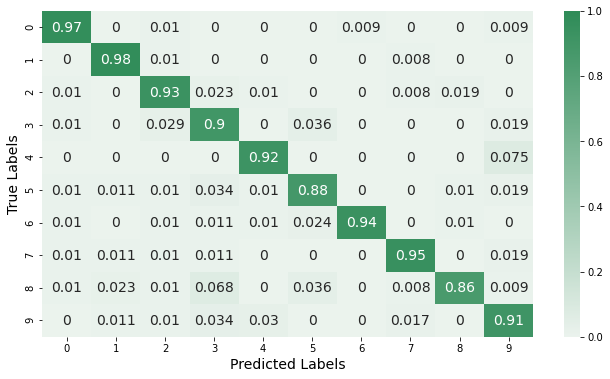

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.96907  0.94000   0.95431
1    1.0    0.97701  0.94444   0.96045
2    2.0    0.93333  0.90741   0.92019
3    3.0    0.89773  0.83158   0.86339
4    4.0    0.92000  0.93878   0.92930
5    5.0    0.88095  0.90244   0.89157
6    6.0    0.93636  0.99038   0.96261
7    7.0    0.94915  0.95726   0.95319
8    8.0    0.85577  0.95699   0.90355
9    9.0    0.90654  0.85841   0.88182



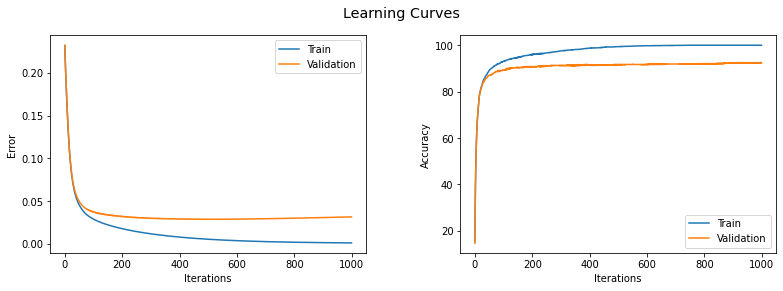

Accuracy

Accuracy on Train Set = 100.0%
Accuracy on Test Set = 92.3%



In [54]:
params_lr_adam, cost_lr_adam, cost_test_lr_adam, y_pred_lr_adam = NeuralNetwork(X_train, y_train,X_test,y_test,layers_lr,0.01,1000,activation_function = 'leaky_relu',optimizer = 'Adam',regularization = None , alpha = 0.1 , alpha2 = 0.01)

## 4.4  Momentum Optimizer

Confusion Matrix :


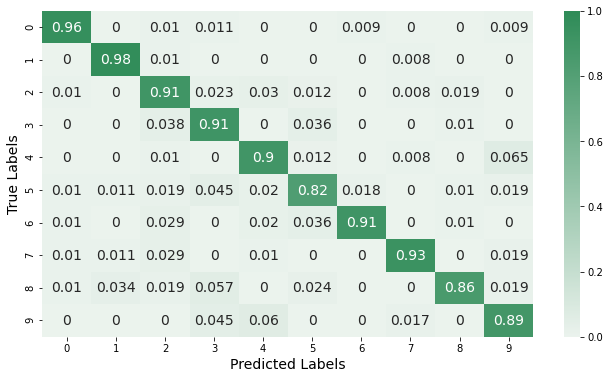

Test Data Stats :
   class  Precision   Recall  F1 Score
0    0.0    0.95876  0.94898   0.95384
1    1.0    0.97701  0.94444   0.96045
2    2.0    0.90476  0.84821   0.87557
3    3.0    0.90909  0.83333   0.86956
4    4.0    0.90000  0.86538   0.88235
5    5.0    0.82143  0.87342   0.84663
6    6.0    0.90909  0.97087   0.93896
7    7.0    0.93220  0.95652   0.94420
8    8.0    0.85577  0.94681   0.89899
9    9.0    0.88785  0.87156   0.87963



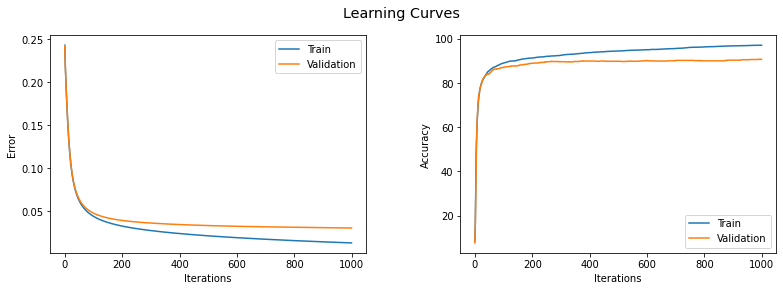

Accuracy

Accuracy on Train Set = 97.05%
Accuracy on Test Set = 90.6%



In [49]:
params_lr_mt, cost_lr_mt, cost_test_lr_mt, y_pred_lr_mt = NeuralNetwork(X_train, y_train,X_test,y_test,layers_lr,0.1,1000,activation_function = 'leaky_relu',optimizer = 'momentum',regularization = None , alpha = 0.01)

In [3]:
!cp Code_2018EE10434_2018EE10470.ipynb Code_2018EE10434_2018EE10470.ipynb



'cp' is not recognized as an internal or external command,
operable program or batch file.
